<a href="https://colab.research.google.com/github/Nour-Rekik/electrical-vehicle-data-Analysis/blob/main/electrical_car_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python code for electric vehicle data analysis**. 
Since our dataset is a semi-structured dataset, we need PySpark to process this data. So let's install Pyspark

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 24 kB/s 
     |████████████████████████████████| 198 kB 50.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=fec5ed4a2c12788e8c9fc760fb9f7cf6951d72f7bdf6d30ba68b9c31bbe87dec
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


First, we need to import some basic libraries.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import NullType
import pyspark.sql.functions as f
import numpy as np


Now we need to connect to the Drive to get access to the Data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Creating Spark Session 

In [4]:
spark1 = SparkSession.builder.appName('clever').getOrCreate()

# **Importing the Data**



In [5]:
data_df =spark1.read.json("/content/drive/MyDrive/test_data.json")

In [ ]:
data_df.show()

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        basicCarInfo|bodyAndChassis|             climate|          driveState|              eMotor|             metaObd|           timestamp|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{[[35511.0, 1.624...|          null|{null, [[23.09999...|{[[551.4020385742...|{[[32, 1624541233...|{null, null, ac:6...|2021-06-24 13:27:...|
|{[[35511.0, 1.624...|          null|{null, [[23.09999...|{[[553.2650146484...|{[[32, 1624541256...|{null, null, ac:6...|2021-06-24 13:27:...|
|{[[35511.0, 1.624...|          null|{null, [[23.09999...|{[[549.7109985351...|{[[32, 1624541278...|{null, null, ac:6...|2021-06-24 13:28:...|
|{[[35511.0, 1.624...|          null|{null, [[23.09999...|{[[548.75, 1.6245...|{[[31, 1624541300...|{null, null, ac:6...|2021-06-24 13:28:...|

Let's have a look to the schema of the Data Set and to get an idea about the type of the columns 

In [ ]:
data_df.printSchema()

root
 |-- basicCarInfo: struct (nullable = true)
 |    |-- odoMeter: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |-- vin: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- bodyAndChassis: struct (nullable = true)
 |    |-- doorBlOpen: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |-- doorBrOpen: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |-- doorFlOpen: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |-- doorFrOpen: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: long (contain

# **Exploratory Data Analysis**

Number of samples

In [ ]:
n= data_df.count()
print ("Our DataSet contain {} sample ".format(n))

Our DataSet contain 720139 sample 


List of the Columns 

In [ ]:
print("There are {} columns in the eClever DataFrame and their names are {}".format(len(data_df.columns), data_df.columns))

There are 7 columns in the eClever DataFrame and their names are ['basicCarInfo', 'bodyAndChassis', 'climate', 'driveState', 'eMotor', 'metaObd', 'timestamp']


Since we have 6 vehicle models, let's calculate the number of vehicles in each model

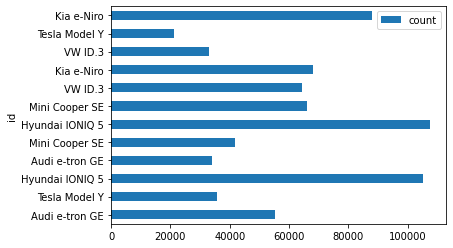

In [ ]:
data_group_by_id= data_df.groupBy("metaObd.id").count()
data_group_by_id
data_id= data_group_by_id.toPandas()
data_id.plot("id","count",kind='barh')
tickvalues = data_id.index
plt.yticks(tickvalues, labels=["Audi e-tron GE","Tesla Model Y", "Hyundai IONIQ 5","Audi e-tron GE", "Mini Cooper SE","Hyundai IONIQ 5", "Mini Cooper SE","VW ID.3","Kia e-Niro","VW ID.3","Tesla Model Y","Kia e-Niro" ])
plt.show()

Check if there are duplicate data

In [ ]:
data_df_nodup = data_df.dropDuplicates()
print("There were {} rows before removing duplicates, and {} rows after removing duplicates".format(data_df.count(), data_df_nodup.count()))

There were 720139 rows before removing duplicates, and 720139 rows after removing duplicates


In [ ]:
null_values= n-(data_df.na.drop().count())
null_values

692390

the above statement shows that we have 692390 missing data, but we still have no idea about :


*   Which column contains the most deletable data?
*   Which vehicle model has the most missing data?



Now let's visualize the amount of missing data in each column

In [ ]:
sample_df = data_df.select(data_df.columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()


So here we see that the "BodyAndChassis" column contains much more deletable data besides the "Climate" column 

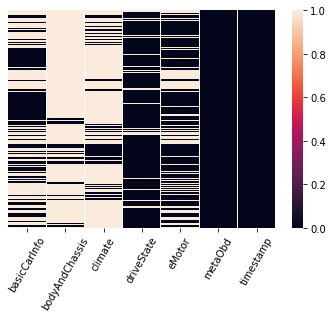

In [ ]:
sns.heatmap(data=tf_df,yticklabels=False)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()


We can see the previous result with more details. So here we will eliminate the columns with more than 60% missing data and show only the rest.

This is good! Here we can see that the columns "Body and chassis" and "Climate" are not included in the list because they contain more than 60% missing data

In [ ]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
    # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
      
    # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(data_df, .6)
df.columns

['basicCarInfo', 'driveState', 'eMotor', 'metaObd', 'timestamp']

Which vehicle model contains more erasable values?

In [ ]:
data_df_VW_ID_3_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:72:ab:24").toPandas()
data_df_VW_ID_3_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6f:e1:50").toPandas()

data_df_tesla_Model_Y_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:85:60").toPandas()
data_df_tesla_Model_Y_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:71:f1:68").toPandas()

data_df_Audi_e_tron_GE_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:85:84").toPandas()
data_df_Audi_e_tron_GE_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:85:44").toPandas()

data_df_Kia_e_Niro_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:72:da:cc").toPandas()
data_df_Kia_e_Niro_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6f:e5:a8").toPandas()

data_df_Hyundai_IONIQ_5_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:cf:d0").toPandas()
data_df_Hyundai_IONIQ_5_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:f1:c0").toPandas()

data_df_Mini_Cooper_SE_M1 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6f:e0:ac").toPandas()
data_df_Mini_Cooper_SE_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:6e:d9:38").toPandas()

After filtering the data by ID, we can see from the diagram that the vehicle model Hyundai_IONIQ_5_M1 contains so many voidable vehicles compared to other models 

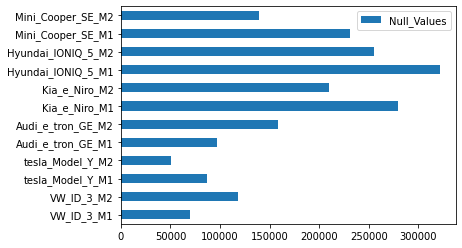

In [ ]:
Models=[data_df_VW_ID_3_M1,data_df_VW_ID_3_M2,data_df_tesla_Model_Y_M1,data_df_tesla_Model_Y_M2,data_df_Audi_e_tron_GE_M1,data_df_Audi_e_tron_GE_M2,data_df_Kia_e_Niro_M1,data_df_Kia_e_Niro_M2,data_df_Hyundai_IONIQ_5_M1,data_df_Hyundai_IONIQ_5_M2,data_df_Mini_Cooper_SE_M1,data_df_Mini_Cooper_SE_M2]
nul =[]
for model in Models :
  x= model.isnull().sum().sum()
  nul.append(x)
df = pd.DataFrame(nul,index =['VW_ID_3_M1', 'VW_ID_3_M2', 'tesla_Model_Y_M1', 'tesla_Model_Y_M2', 'Audi_e_tron_GE_M1', 'Audi_e_tron_GE_M2', 'Kia_e_Niro_M1','Kia_e_Niro_M2','Hyundai_IONIQ_5_M1','Hyundai_IONIQ_5_M2','Mini_Cooper_SE_M1','Mini_Cooper_SE_M2'], columns =['Null_Values'])
df.plot(kind='barh')


Conversion from timestamp to date 

In [ ]:
time_convert= data_df.withColumn("timestamp", f.to_date(f.from_unixtime(f.col("timestamp"))))

In [ ]:
time_convert.show()

+------------+------------+-----------------+-----+----------+
|eCUversionHW|eCUversionSW|               id|state| timestamp|
+------------+------------+-----------------+-----+----------+
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021-06-24|
|        null|        null|ac:67:b2:6e:85:44| null|2021

Now that we have figured out which model contains the most deletable data, let's trace its origin

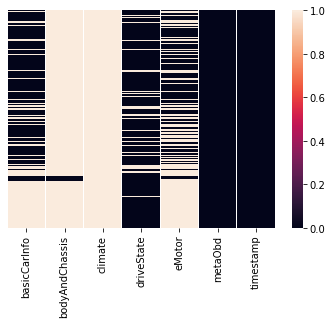

In [ ]:
# Convert all values to T/F
tf_df = data_df_Hyundai_IONIQ_5_M1.isnull()

sns.heatmap(data=tf_df,yticklabels=False)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

We can now confirm that the origin is from the "Climate" and "BodyAndChassis" columns. Especially the column "Climate", because it is completely invalid. I became curious about the Hyundai_IONIQ_5_M2

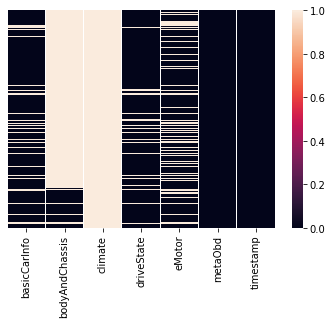

In [ ]:
# Convert all values to T/F
tf_df = data_df_Hyundai_IONIQ_5_M2.isnull()

sns.heatmap(data=tf_df,yticklabels=False)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

To better understand this problem and to find out if the climate is an important information or not and if we can compensate these wrong values? 

I have an idea! How about interpreting the effect of the outside temperature on the temperature of the battery. Let's show this relationship between these two attributes for a different model, tesla_Model_Y_M2, since it contains less erasable data.


In [ ]:
data_df_tesla_Model_Y_M2 = data_df.filter(data_df.metaObd.id == "ac:67:b2:71:f1:68")
selected_data=data_df_tesla_Model_Y_M2.select(col("climate.outsideAirTemp"),col("eMotor.hvBatteryTemp")).sample(False, 0.5, 42)
selected_data_pandas=selected_data.toPandas()


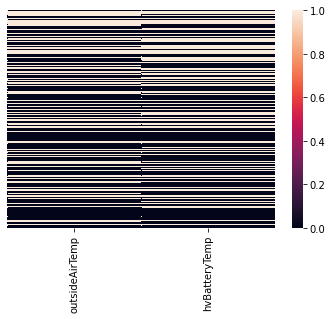

In [ ]:
tf_df = selected_data_pandas.isnull()

sns.heatmap(data=tf_df,yticklabels=False)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

This is a good sign, because we can see that these attributes do not contain so much missing data, so we can see the relationship between them

In [ ]:
index=selected_data_pandas.index

x=np.array(selected_data_pandas["outsideAirTemp"])
y=np.array(selected_data_pandas["hvBatteryTemp"])
ouTemp=[]
for i in x :
  if (isinstance(i,list)):
    ouTemp= ouTemp+i
  else : 
    np.append(ouTemp,i)

OT=[]
for f in ouTemp :
  OT=OT+f


BattTemp=[]
for i in y :
  if (isinstance(i,list)):
    BattTemp= BattTemp+i
  else : 
    np.append(BattTemp,i)

BT=[]
for f in BattTemp :
  BT=BT+f


In [ ]:
BT =BT [13380:]
OT = OT[13400:]

20 20


Here we can see that the outside temperature and the battery temperature have the same deviation. This is a sign that confirms us that the outside temperature has an influence on the battery temperature.

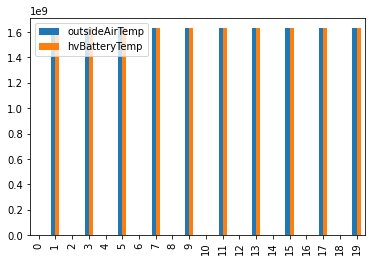

In [ ]:
df2 = pd.DataFrame({'outsideAirTemp':OT,
                    'hvBatteryTemp':BT})
df2.plot.bar();

We will analyze each column separately, starting with Motor Data


Count the percentage of missing values

In [ ]:
eMotor_df = data_df.select(col("eMotor.*"))
type(eMotor_df.columns)
eMotor_df_pandas =eMotor_df.toPandas()
# Checking basic statistics
eMotor_df_pandas.describe()

,dcDcConverterTemp,eMotorActualCurrent,eMotorTemp,hvAvailableChargePower,hvAvailableDischargePower,hvBatteryCurrent,hvBatteryTemp,hvBatteryTempAvg,hvBatteryTempMax,hvBatteryTempMin,...,hvChargePhasen,hvChargePower,hvChargeTimeToFullManufacturer,hvCoolingTemp,hvPowerElectronicTemp,hvSocActualBms,hvSocActualDisplay,hvStateOfHealth,rangeManufacturer,rpmEmotor
0,"[[32, 1624541233]]","[[0.7, 1624541236.0]]","[[22.125, 1624541235.0]]",None,None,"[[-1.8, 1624541231.0]]","[[19.0, 1624541232.0]]",None,None,None,...,None,"[[0, 1624541234]]",None,"[[19.0, 1624541232.0]]","[[23, 1624541233]]","[[94.12, 1624541231.0]]","[[98.0, 1624541234.0]]",None,None,"[[0, 1624541231]]"
1,"[[32, 1624541256]]","[[0.9, 1624541258.0]]","[[22.125, 1624541258.0]]",None,None,"[[-1.9, 1624541254.0]]","[[19.0, 1624541254.0]]",None,None,None,...,None,"[[0, 1624541256]]",None,"[[19.0, 1624541254.0]]","[[22, 1624541256]]","[[94.12, 1624541254.0]]","[[98.0, 1624541256.0]]",None,None,"[[0, 1624541253]]"
2,"[[32, 1624541278]]","[[0.8, 1624541280.0]]","[[22.125, 1624541280.0]]",None,None,"[[-2.1, 1624541276.0]]","[[19.0, 1624541276.0]]",None,None,None,...,None,"[[0, 1624541278]]",None,"[[19.0, 1624541276.0]]","[[23, 1624541278]]","[[94.12, 1624541276.0]]","[[98.0, 1624541278.0]]",None,None,"[[0, 1624541275]]"
3,"[[31, 1624541300]]","[[85.2, 1624541302.0]]","[[22.375, 1624541302.0]]",None,None,"[[-2.7, 1624541298.0]]","[[19.0, 1624541298.0]]",None,None,None,...,None,"[[0, 1624541300]]",None,"[[19.0, 1624541299.0]]","[[23, 1624541300]]","[[94.12, 1624541298.0]]","[[98.0, 1624541300.0]]",None,None,"[[-78, 1624541297]]"
4,"[[30, 1624541322]]","[[73.8, 1624541324.0]]","[[22.75, 1624541324.0]]",None,None,"[[-4.5, 1624541320.0]]","[[19.0, 1624541321.0]]",None,None,None,...,None,"[[0, 1624541323]]",None,"[[19.0, 1624541321.0]]","[[23, 1624541322]]","[[94.12, 1624541320.0]]","[[98.0, 1624541323.0]]",None,None,"[[16, 1624541319]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720134,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
720135,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
720136,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
720137,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Count percentage of missing values
missing_percentages = eMotor_df_pandas.isna().sum().sort_values(ascending=False) / len(df) * 100
missing_percentages

hvBatteryTempAvg                  3418.761869
eMotorActualCurrent               3300.104444
hvCellVoltageAvg                  3281.048234
hvChargePhasen                    3273.414356
hvChargeTimeToFullManufacturer    3273.157995
hvCellSocMin                      3172.811432
hvCellSocMax                      3172.778200
eMotorTemp                        3154.500570
hvChargePower                     3149.700912
hvPowerElectronicTemp             3149.610710
dcDcConverterTemp                 3149.610710
hvCellVoltages                    3096.539119
hvAvailableDischargePower         2981.717622
hvAvailableChargePower            2981.717622
rangeManufacturer                 2786.109001
hvBatteryTempMin                  2745.437714
hvBatteryTempMax                  2745.413976
hvCellDeviationVoltage            2535.078807
hvStateOfHealth                   2304.975313
rpmEmotor                         1957.206608
hvCellVoltageMax                  1764.009685
hvCellVoltageMin                  

Here we see that, for example, for the temperature of the battery (Temp max, Temp min, Temp Avg). As the average temperature contains a large amount of missing data, we can replace this data by calculating the average value from the maximum and minimum values

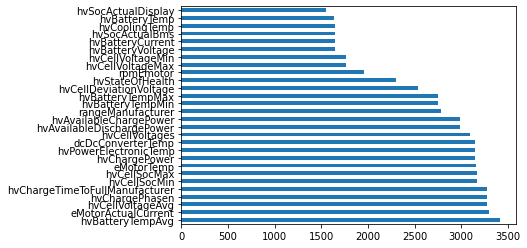

In [ ]:
missing_percentages[missing_percentages != 0].plot(kind='barh');

What about tracking energy consumption throughout the data set? 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


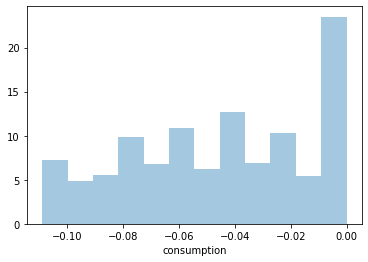

In [ ]:
data_new=data_df.na.drop()
motor_df = data_new.select(col("eMotor.hvBatteryCurrent"),col("metaObd.id"))
pandas_motor_df = motor_df.toPandas()
hvBatteryCurrent= pandas_motor_df["hvBatteryCurrent"]
sum = 0
x=[]
for liste in hvBatteryCurrent:
  if liste != None :
    for j in liste:
      sum=sum+j[0]
      consumption = sum / 1000 / 3600  # kWh
      x.append(consumption)
  else :
    x.append(0)

df = pd.DataFrame(x)
df.rename(columns={0:'consumption'}, inplace = True)
id=pandas_motor_df["id"]
result = pd.concat([id, df], axis=1)

data=result.consumption.drop(0)
sns.distplot(data,bins=12, kde=False, norm_hist=True)
plt.show()


Most consumable energy car 

In [ ]:
most=result.groupby("id")["consumption"].sum().sort_values(ascending=False)
most

id
ac:67:b2:72:ab:24   -537.898786
ac:67:b2:6f:e1:50   -627.411614
Name: consumption, dtype: float64

Let's now compare the energy consumption between the Tesla model and the Volkswagen model. Let's first add a column that represents the energy consumption.

In [ ]:
motor_df = data_df.select(col("eMotor.hvBatteryCurrent"),col("metaObd.id"))
motor_non_null=motor_df.na.drop()

#data_df_tesla_Model_Y_M2
data_df_VW_ID_3 = motor_non_null.filter(data_df.metaObd.id == "ac:67:b2:72:ab:24").toPandas()

#data_df_VW_ID_3_M1
data_df_tesla_Model_Y = motor_non_null.filter(data_df.metaObd.id == "ac:67:b2:71:f1:68").toPandas()
data_df_tesla_Model_Y.info()



In [ ]:
data_df_VW_ID_3['energie_consumption'] = data_df_VW_ID_3.apply(lambda row: np.sum(row['hvBatteryCurrent'])/1000/3600, axis=1)
data_df_tesla_Model_Y['energie_consumption'] = data_df_tesla_Model_Y.apply(lambda row: np.sum(row['hvBatteryCurrent'])/1000/3600, axis=1)



In [ ]:
data_df_VW_ID_3.head()

,hvBatteryCurrent,id,energie_consumption
0,"[[-9.71, 1628241568.0]]",ac:67:b2:72:ab:24,452.289322
1,"[[-4.7, 1628241590.0]]",ac:67:b2:72:ab:24,452.289329
2,"[[-0.37, 1628241613.0]]",ac:67:b2:72:ab:24,452.289337
3,"[[-0.31, 1628241635.0]]",ac:67:b2:72:ab:24,452.289343
4,"[[-0.44, 1628241658.0]]",ac:67:b2:72:ab:24,452.289349


We will take only 6 samples from the Pandas series, and we should take the same number at the same interval to get a good comparative study.

In [ ]:
x= (data_df_VW_ID_3['energie_consumption']).take([0,1,2,3,4,5])

In [ ]:
y=data_df_tesla_Model_Y['energie_consumption'].take([0,1,2,3,4,5])

Interesting. It seems that there is not much difference in energy consumption between Tesla and *Volkswagen*. 

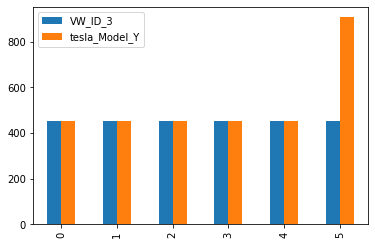

In [ ]:
df2 = pd.DataFrame({'VW_ID_3':x,
                    'tesla_Model_Y':y})
df2.plot.bar();

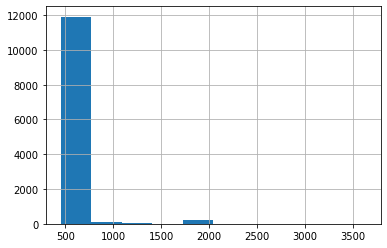

In [ ]:
tesla_Model_Y = data_df_tesla_Model_Y['energie_consumption']
tesla_Model_Y.hist()

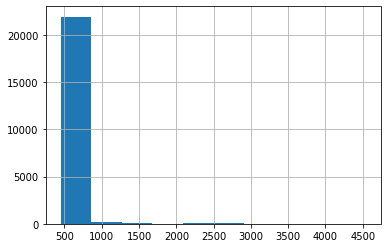

In [ ]:
VW_ID_3 = data_df_VW_ID_3['energie_consumption']
VW_ID_3.hist()

# Correlation Study

**Correlation between the number of turns per minute of the motor and the speed of the car:**

In [6]:
motor_speed_df = data_df.select(col("eMotor.rpmEmotor"),col("driveState.speed")).sample(False, 0.06, 200)
motor_speed_df_pandas=motor_speed_df.toPandas()

In [12]:
x=np.array(motor_speed_df_pandas["rpmEmotor"])
y=np.array(motor_speed_df_pandas["speed"])
ouTemp=[]
for i in x :
  if (isinstance(i,list)):
    ouTemp= ouTemp+i[0]
  else : 
    np.append(ouTemp,i)

OT=[]
for f in ouTemp :
  OT=OT+f


BattTemp=[]
for i in y :
  if (isinstance(i,list)):
    BattTemp= BattTemp+i[0]
  else : 
    np.append(BattTemp,i)

BT=[]
for f in BattTemp :
  BT=BT+f



In [13]:
OT_df = pd.DataFrame(OT)
BT_df=pd.DataFrame(BT)
OT_df.rename(columns={0:'rpmEmotor'}, inplace = True)
BT_df.rename(columns={0:'speed'}, inplace = True)
result = pd.concat([OT_df, BT_df], axis=1)

In [14]:
result["rpmEmotor"].corr(result["speed"])


0.999995288569794

I'm curious about the relationship between the speed and the longitude of a vehicle, so let's calculate the correlation between them.

In [23]:
longitude_speed_df = data_df.select(col("driveState.speed"),col("driveState.longitude")).sample(False, 0.06, 200)
longitude_speed_df_pandas=longitude_speed_df.toPandas()
z=np.array(longitude_speed_df_pandas["longitude"])
longi=[]
for i in z :
  if (isinstance(i,list)):
    longi= longi+i
  else : 
    np.append(longi,i)

longitude=[]
for f in longi :
  longitude=longitude+f

longi_df=pd.DataFrame(longitude)
longi_df.rename(columns={0:'longitude'}, inplace = True)


In [24]:
longitude_speed = pd.concat([longi_df, BT_df], axis=1)
longitude_speed["longitude"].corr(longitude_speed["speed"])


0.9999957434955266


After studying the correlation between the above columns, we can conclude the following:



*   The correlation between speed and the rmpEmotor is very weak, which is logical.

*   The correlation between the speed and the length of the vehicle is also very weak, confirming that the design of the vehicle has an influence on its mechanical behavior. 

* The correlation between speed and both longitude and rpmEmotor shows that there is a weak positive linear relationship between the variables, which can help predict the speed with only one of them, since they have the same correlation with the variable "speed".





# Conclusion

Conclusion and potential work: After extracting numerous pieces of information from the given datasets, and after studying the relationship between different columns, we might say that the data is rich and has many insights, even though some of them are ambiguous. From there, we can implement a supervised model which predicts the energy consumption of an electrical car, or even we can go further and try to cluster different data using unsupervised models to get more insights and relation between the columns. Overall, the dataset is interesting enough to do more interesting work, and even some extra columns could result in better modeling.